In [1]:
import itertools
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import torch
from torch import Tensor
from torch.nn import Module, Linear
import torch.nn.functional as F
from torch.optim import SGD
from torch import special
from tqdm import tqdm

## Load data

> ![NOTE]
> James has kindly sent me the preprocessed and translated data, as well as the trained alphabet.
> I have taken the files he has sent me and saved them in on my local machine inside an ignored directory called "ignore".
> Hence the below lines, but note that they won't run on your machine unless you have copies of the data too.

In [2]:
alphabet = pd.read_csv("../ignore/alphabet.csv", index_col=0)
data = pd.read_csv("../ignore/translation_train.csv", index_col=0, dtype=str)
olga_marginal = pd.read_csv("../ignore/average_olga_vector.csv", header=None).values.squeeze()

olga_marginal = torch.tensor(olga_marginal, dtype=torch.float32)

In [3]:
alphabet

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
Letter,0,1,0,1,0,1,1,0,1,0,0,0,0,1,1,1,0,0,0,1


In [4]:
data.head()

,CDR3B,epitope,Assays,translation_CDR3B,translation_epitope
0,LGSGGTDTQY,GGALQ,"dextramer-sort,dextramer-sort",0111100011,11001
1,LGSGGTDTQY,GGALQ,"dextramer-sort,dextramer-sort",0111100011,11001
2,LASGRSTEAF,RAEAQ,multimer/tetramer,0011110100,10101
3,SGTGGQYEQY,FHLYL,tetramer-sort,1101111111,01010
4,QARLYQETQY,CTLVA,multimer/tetramer,1010111011,10000


In [5]:
olga_marginal

tensor([0.4545, 0.5267, 0.5968, 0.6162, 0.5930, 0.4447, 0.6064, 0.6376, 0.6993,
        0.5556])

In [6]:
def compute_epitope_priors(epi_length: int, num_ones_in_alphabet: int) -> dict:
    """
    Compute the prior probability of each epitope of length `epi_length` given the alphabet.
    """
    prob_one = num_ones_in_alphabet / 20
    prob_zero = 1 - prob_one

    possible_epitopes = [tuple(prod) for prod in itertools.product([0,1], repeat=epi_length)]
    
    def compute_prob(epitope: tuple) -> float:
        return prob_one ** epitope.count(1) * prob_zero ** epitope.count(0)
    
    return {epitope: compute_prob(epitope) for epitope in possible_epitopes}

In [7]:
num_ones_in_alphabet = int(alphabet.loc["Letter"].sum())
epitope_priors = compute_epitope_priors(5, num_ones_in_alphabet)

In [8]:
# Turn translated sequences into torch tensors
def map_zero_one_string_to_tensor(zero_one_string: str) -> Tensor:
    return torch.tensor([float(char) for char in zero_one_string])

tcr_tensor = torch.stack(data["translation_CDR3B"].map(map_zero_one_string_to_tensor).tolist())
epitope_tensor = torch.stack(data["translation_epitope"].map(map_zero_one_string_to_tensor).tolist())

## Define Dumpy

In [9]:
class Dumpy(Module):
    def __init__(self, in_features: int, out_features: int):
        super(Dumpy, self).__init__()
        self.linear = Linear(in_features=in_features, out_features=out_features, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return special.expit(x)

    def forward_logit(self, x):
        return self.linear(x)

## Train

Here the hyperparameter **lambda** (`lmb` in code) is the relative weighting of the **marginal loss term** (how close the model's marginal TCR distribution is to the target OLGA marginal) compared to the **conditional loss term** (how well the model can predict TCR given epitope).
I execute 10 different training runs with varying lambda, to see which lambda we like the trade-off of most.
This trade-off is evaluated later down in the notebook.

In [10]:
def train(epitope_tensor: Tensor, tcr_tensor: Tensor, epitope_priors: dict[tuple, float], target_marginal: Tensor, lmb: float, epochs: int = 5000):
    model = Dumpy(5, 10)
    optimizer = SGD(model.parameters(), lr=1)

    losses = []

    for _ in tqdm(range(epochs)):
        optimizer.zero_grad()

        model_output = model.forward_logit(epitope_tensor)
        model_marginal = compute_model_marginal(model, epitope_priors)
        conditional_loss = F.binary_cross_entropy_with_logits(model_output, tcr_tensor)
        marginal_loss = F.binary_cross_entropy(model_marginal, target_marginal.unsqueeze(0))
        loss = conditional_loss + lmb * marginal_loss

        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f"Lambda: {lmb}")
    print(f"Conditional loss: {conditional_loss.item()}")
    print(f"Marginal loss: {marginal_loss.item()}")

    plt.figure(figsize=(3,1))
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return model, conditional_loss.item(), marginal_loss.item()

def compute_model_marginal(model: Module, epitope_priors: dict[tuple, float]) -> Tensor:
    weighted_conditionals = [model.forward(torch.tensor(epitope, dtype=torch.float32).unsqueeze(0)) * epitope_prior for epitope, epitope_prior in epitope_priors.items()]
    return torch.sum(torch.stack(weighted_conditionals, dim=0), dim=0)

def compute_average_data_likelihood(model: Module, epitope_tensor: Tensor, tcr_tensor: Tensor) -> float:
    model_output = model.forward_logit(epitope_tensor)
    return F.binary_cross_entropy_with_logits(model_output, tcr_tensor).item()

100%|██████████| 5000/5000 [00:10<00:00, 496.10it/s]

Lambda: 0.10000000149011612
Conditional loss: 0.660151481628418
Marginal loss: 0.673890233039856


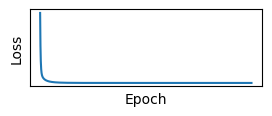

100%|██████████| 5000/5000 [00:09<00:00, 506.00it/s]

Lambda: 0.1668100506067276
Conditional loss: 0.6602367162704468
Marginal loss: 0.6732418537139893


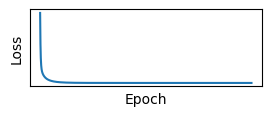

100%|██████████| 5000/5000 [00:10<00:00, 497.04it/s]

Lambda: 0.2782559394836426
Conditional loss: 0.660391628742218
Marginal loss: 0.6725309491157532


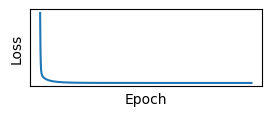

100%|██████████| 5000/5000 [00:09<00:00, 551.33it/s]

Lambda: 0.46415889263153076
Conditional loss: 0.660629153251648
Marginal loss: 0.6718721389770508


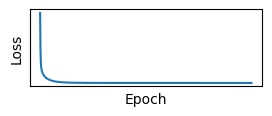

100%|██████████| 5000/5000 [00:09<00:00, 553.85it/s]

Lambda: 0.7742636799812317
Conditional loss: 0.6609311103820801
Marginal loss: 0.6713662147521973


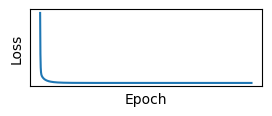

100%|██████████| 5000/5000 [00:09<00:00, 550.46it/s]

Lambda: 1.2915496826171875
Conditional loss: 0.6612505912780762
Marginal loss: 0.671042799949646


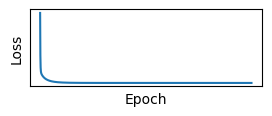

100%|██████████| 5000/5000 [00:08<00:00, 556.29it/s]


Lambda: 2.1544346809387207
Conditional loss: 0.6615387201309204
Marginal loss: 0.670866847038269


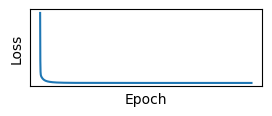

100%|██████████| 5000/5000 [00:09<00:00, 551.58it/s]

Lambda: 3.59381365776062
Conditional loss: 0.6617672443389893
Marginal loss: 0.670782744884491


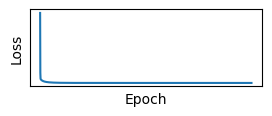

100%|██████████| 5000/5000 [00:09<00:00, 506.51it/s]

Lambda: 5.994842529296875
Conditional loss: 0.6619318723678589
Marginal loss: 0.6707464456558228


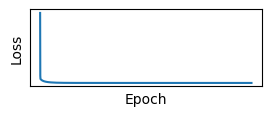

100%|██████████| 5000/5000 [00:09<00:00, 543.92it/s]

Lambda: 10.0
Conditional loss: 0.6620428562164307
Marginal loss: 0.6707316040992737


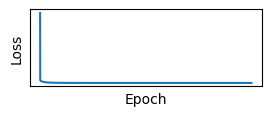

In [11]:
lmbs = torch.logspace(-1, 1, 10)
results = {lmb.item(): train(epitope_tensor, tcr_tensor, epitope_priors, olga_marginal, lmb) for lmb in lmbs}

## Inspect different pareto-optimal models

In [12]:
conditional_losses = [result[1] for result in results.values()]
marginal_losses = [result[2] for result in results.values()]
results_table = pd.DataFrame({"Lambda": results.keys(), "Conditional loss": conditional_losses, "Marginal loss": marginal_losses})

In [13]:
results_table

,Lambda,Conditional loss,Marginal loss
0,0.100000,0.660151,0.673890
1,0.166810,0.660237,0.673242
2,0.278256,0.660392,0.672531
3,0.464159,0.660629,0.671872
4,0.774264,0.660931,0.671366
5,1.291550,0.661251,0.671043
6,2.154435,0.661539,0.670867
7,3.593814,0.661767,0.670783
8,5.994843,0.661932,0.670746
9,10.000000,0.662043,0.670732


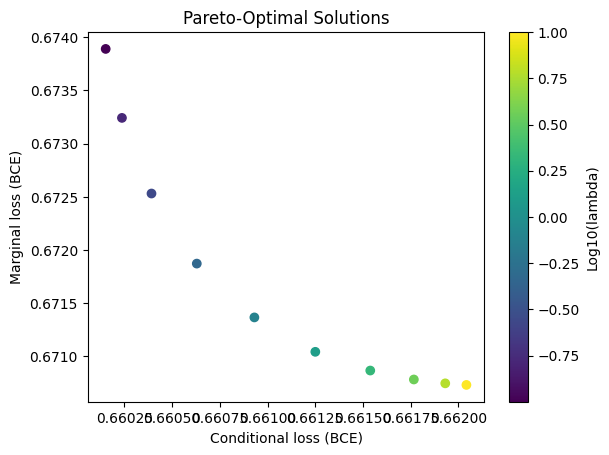

In [14]:
plt.figure()

scatter = plt.scatter(results_table["Conditional loss"], results_table["Marginal loss"], c=np.log10(results_table["Lambda"]))
plt.colorbar(scatter, label="Log10(lambda)")

plt.title("Pareto-Optimal Solutions")
plt.xlabel("Conditional loss (BCE)")
plt.ylabel("Marginal loss (BCE)")

plt.show()

In [22]:
lambda_of_choice = results_table["Lambda"].iloc[4]

## Make joint model

The `Dumpy` model on its own can only compute the conditional distribution of TCRs given epitope.
A combination of a Dumpy instance and a prior distribution over the epitope hypercube gives you the full joint distribution.
I implement a class below which concretises this idea.

In [23]:
class DumpyJoint:
    def __init__(self, dumpy_model: Dumpy, epitope_priors: dict[tuple, float]):
        self.dumpy_model = dumpy_model
        self.tcr_dimensionality = dumpy_model.linear.out_features
        self.epitope_dimensionality = dumpy_model.linear.in_features
        self.epitope_priors = epitope_priors

    @torch.no_grad()
    def joint(self, tcrs: Tensor, epitopes: Tensor) -> Tensor:
        """
        Parameters
        ----------
        tcrs : Tensor
            A tensor of shape (n_tcrs, n_tcr_features) representing TCRs.

        epitopes : Tensor
            A tensor of shape (n_epitopes, n_epitope_features) representing epitopes.

        Returns
        -------
        Tensor
            A matrix of joint probabilities of TCRs and epitopes.
            The shape of the output matrix is (n_tcrs, n_epitopes).
            That is, this function computes the probability of all pairs between input TCRs and epitopes.
        """
        tcr_distributions = self.dumpy_model.forward(epitopes)
        conditional_tcr_probs = self._get_likelihood(tcrs, tcr_distributions)
        marginal_epitope_probs = self._get_epitope_marginals(epitopes)
        return marginal_epitope_probs.unsqueeze(0) * conditional_tcr_probs

    def _get_likelihood(self, target: Tensor, distribution: Tensor) -> Tensor:
        """
        Parameters
        ----------
        target : Tensor
            A tensor of shape (n_instances, n_features) containing the instnance vectors (e.g. TCRs).

        distribution : Tensor
            A tensor of shape (n_generators, n_features) containing vectors representing generative distributions (e.g. TCR distributions).
        
        Returns
        -------
        Tensor
            A tensor of shape (n_instances, n_generators) containing the likelihood of each instance given each of the generators.
        """
        distribution = distribution.unsqueeze(0)
        target = target.unsqueeze(1)
        return torch.prod(target * distribution + (1 - target) * (1 - distribution), dim=-1)

    def _get_epitope_marginals(self, epitopes: Tensor) -> Tensor:
        epitopes_as_tuples = [tuple(epitope.to(int).tolist()) for epitope in epitopes]
        marginals = [self.epitope_priors[epitope] for epitope in epitopes_as_tuples]
        return torch.tensor(marginals)

In [24]:
joint_model = DumpyJoint(results[lambda_of_choice][0], epitope_priors)
mini_tcr_tensor = tcr_tensor[:5]
mini_epitope_tensor = epitope_tensor[:5]

In [25]:
joint_model.joint(mini_tcr_tensor, mini_epitope_tensor)

tensor([[5.4924e-05, 5.4924e-05, 4.8018e-05, 8.0624e-05, 5.9823e-05],
        [5.4924e-05, 5.4924e-05, 4.8018e-05, 8.0624e-05, 5.9823e-05],
        [3.4248e-05, 3.4248e-05, 1.7434e-05, 4.1204e-05, 2.9200e-05],
        [4.5942e-05, 4.5942e-05, 8.6054e-05, 4.9204e-05, 7.4686e-05],
        [1.4537e-05, 1.4537e-05, 3.4583e-05, 2.2555e-05, 2.9546e-05]])

In [26]:
all_possible_tcrs = torch.stack([torch.tensor(prod, dtype=torch.float32) for prod in itertools.product([0,1], repeat=10)])
all_possible_epitopes = torch.stack([torch.tensor(epitope, dtype=torch.float32) for epitope in epitope_priors.keys()])
joint_model.joint(all_possible_tcrs, all_possible_epitopes).sum() # Should be 1, sanity check

tensor(1.)

## AUCs

/home/ynagano/Projects/cruk_datathon_team_6/.venv/lib64/python3.12/site-packages/sklearn/utils/_plotting.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


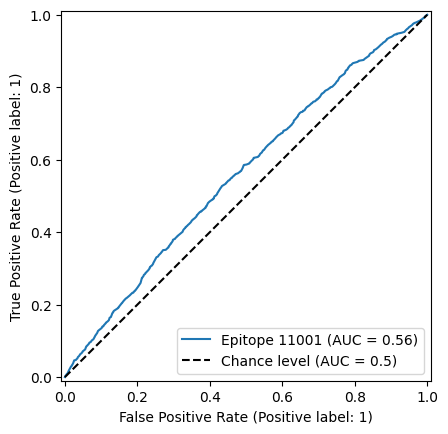

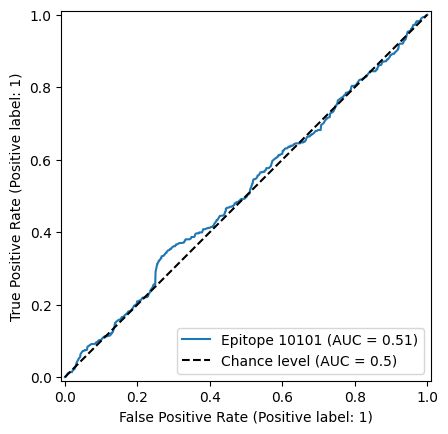

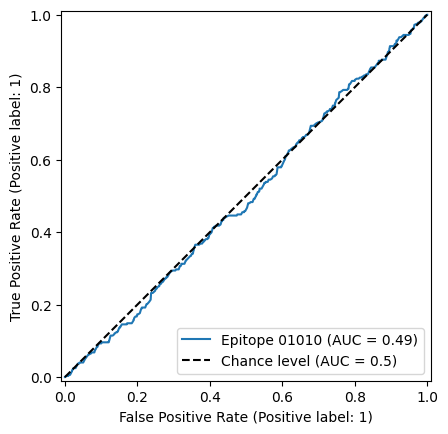

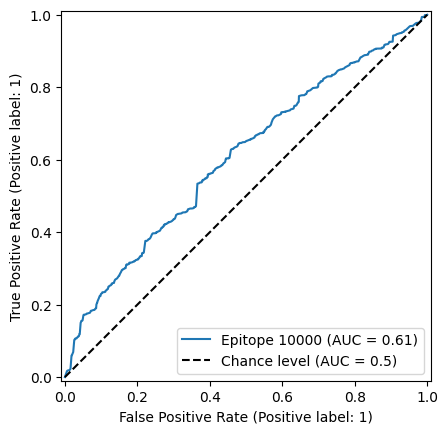

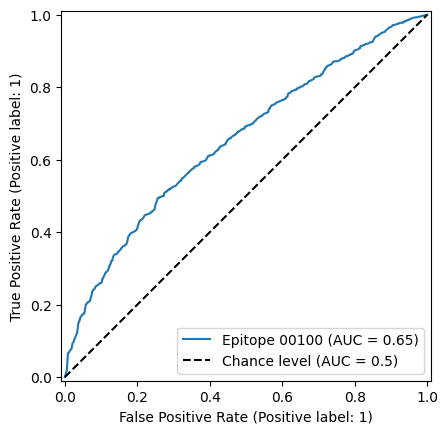

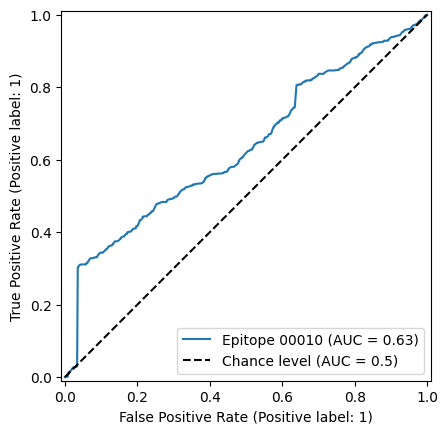

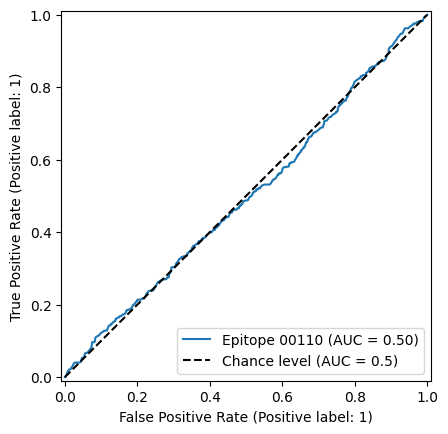

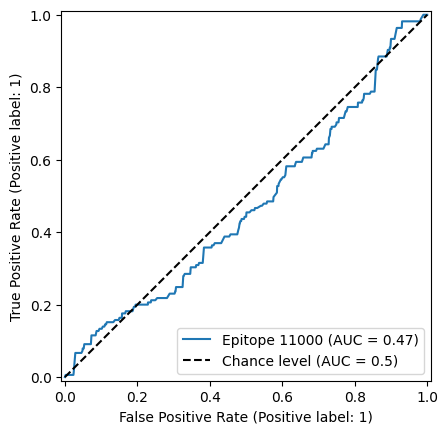

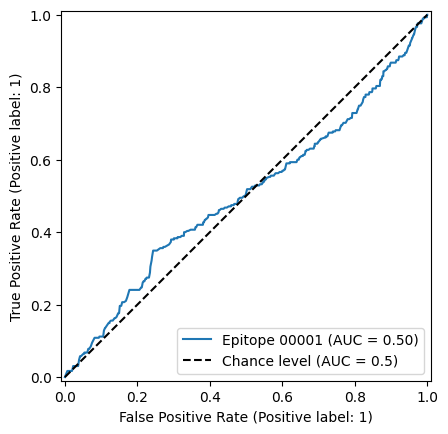

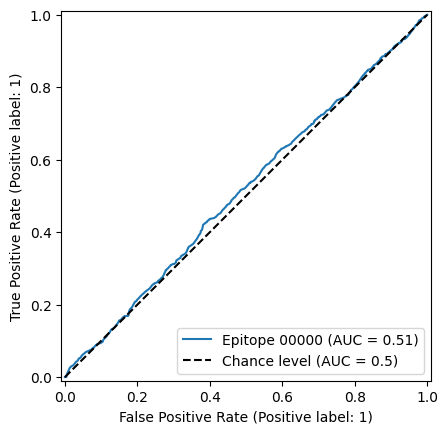

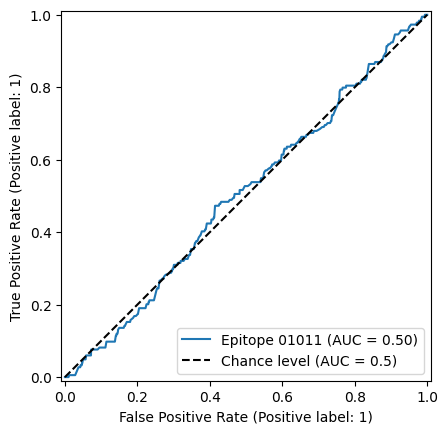

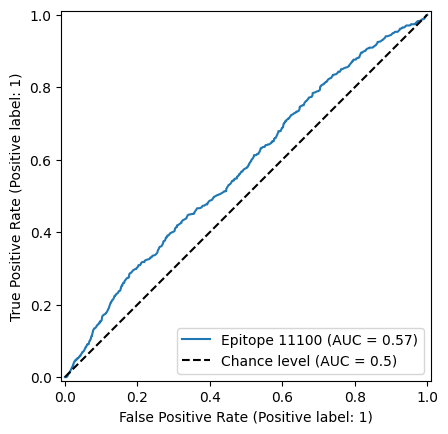

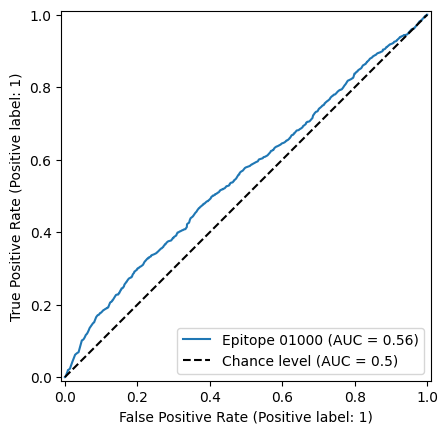

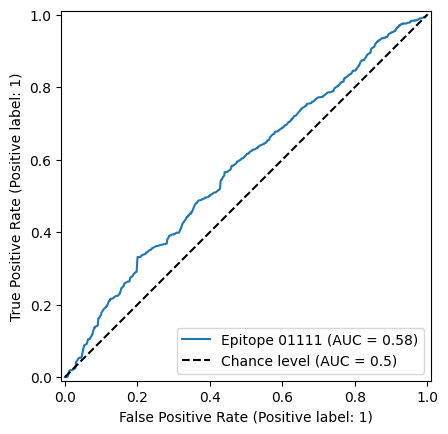

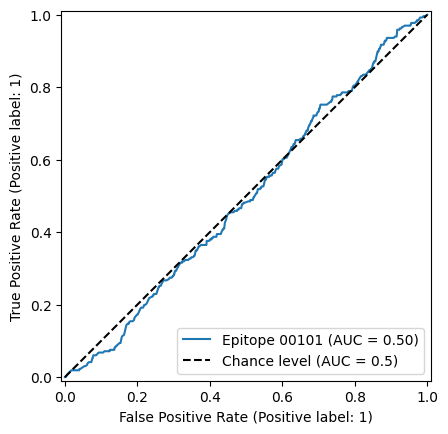

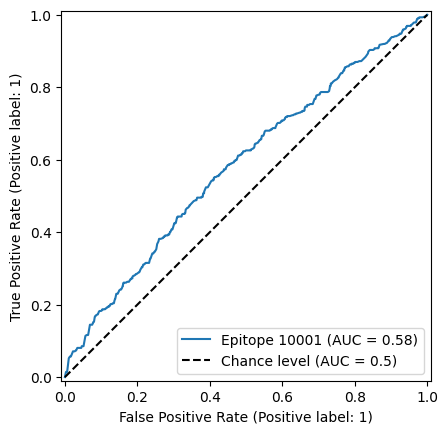

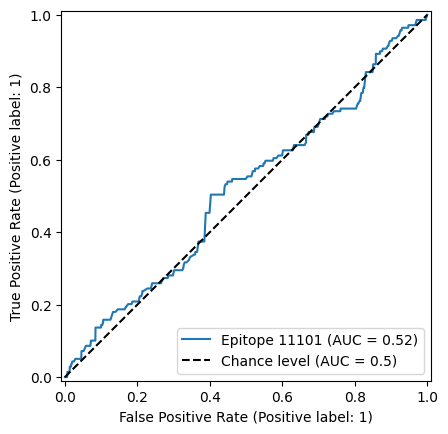

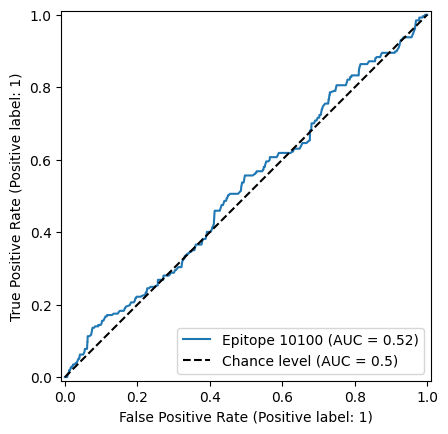

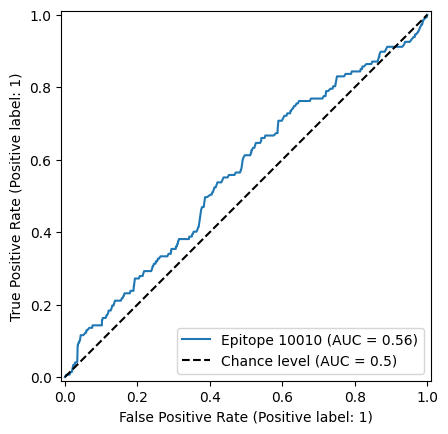

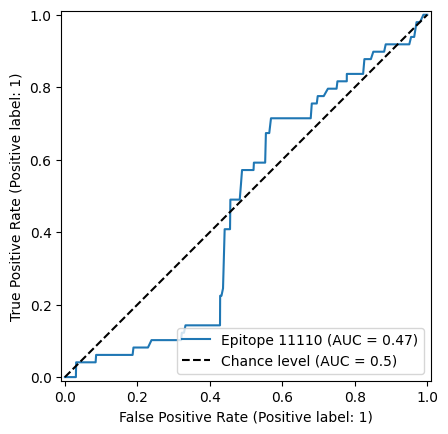

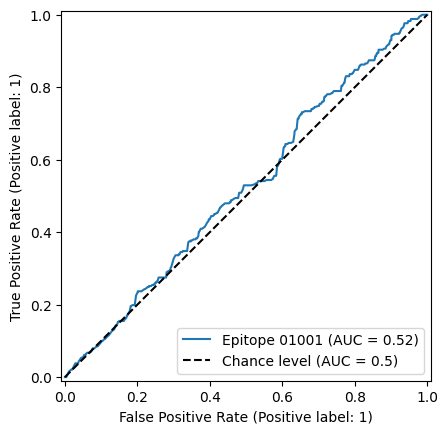

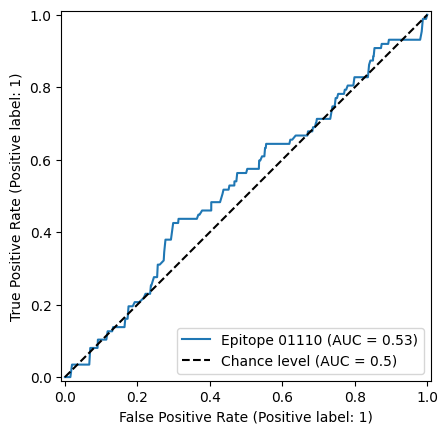

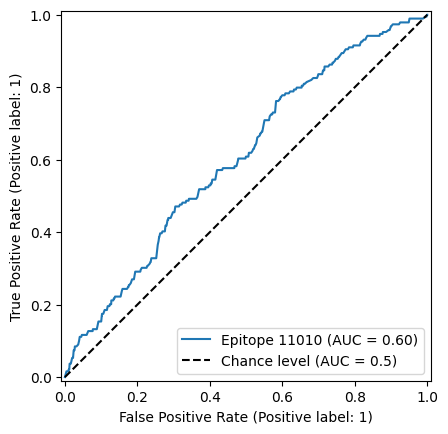

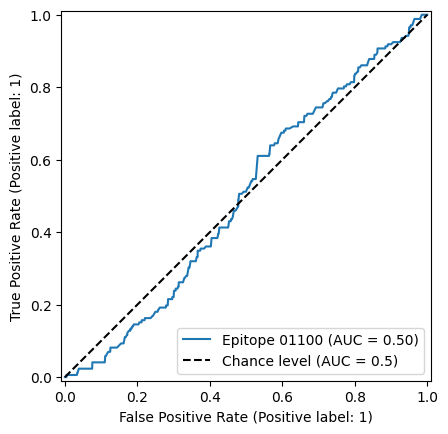

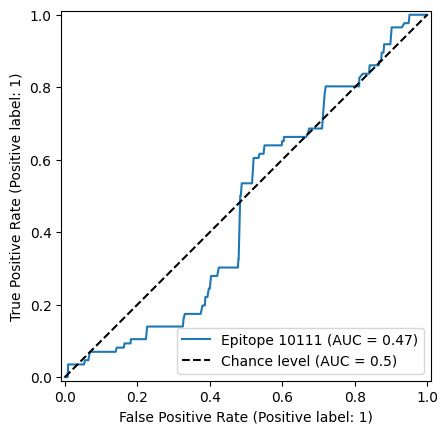

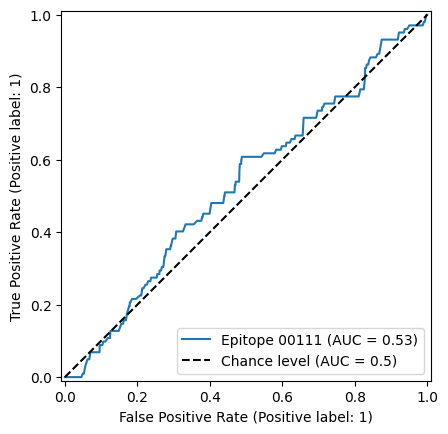

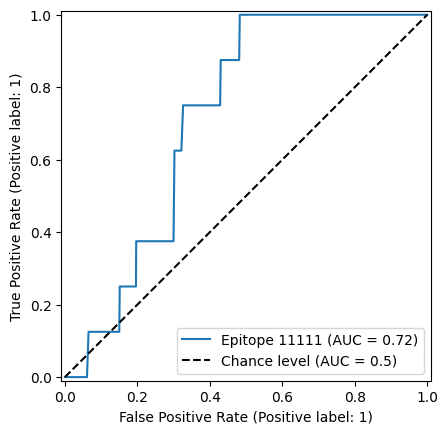

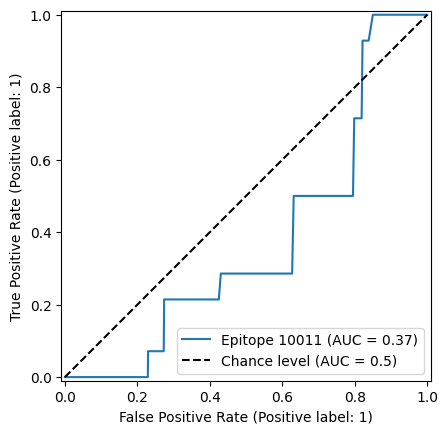

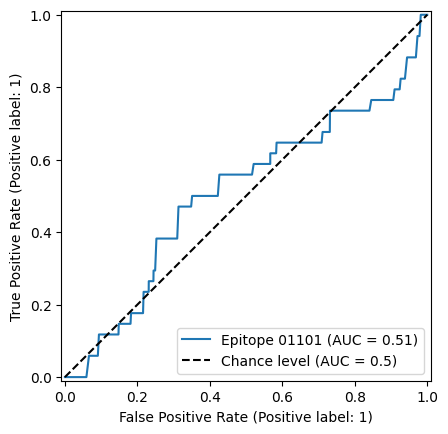

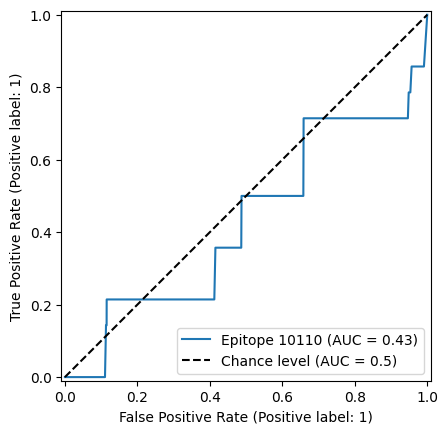

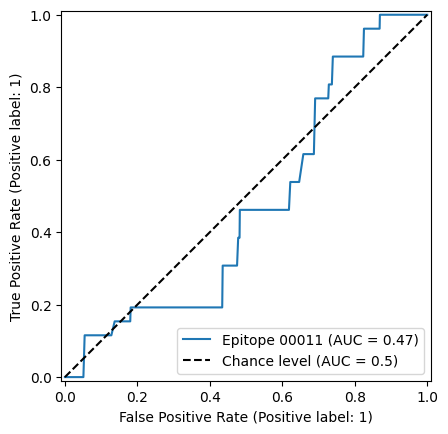

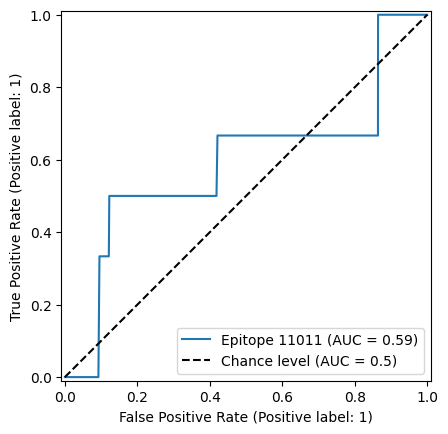

In [27]:
unique_epitopes = data["translation_epitope"].unique()
all_epitopes = epitope_tensor.unique(dim=0)

for epitope in unique_epitopes:
    positive_indices = (data["translation_epitope"] == epitope).to_numpy()
    negative_indices = ~positive_indices

    positive_tcrs = tcr_tensor[positive_indices]
    negative_tcrs = tcr_tensor[negative_indices]
    target_epitope = epitope_tensor[positive_indices][:1]

    p_target_ep_positives = joint_model.joint(positive_tcrs, target_epitope).squeeze()
    p_all_eps_positives = joint_model.joint(positive_tcrs, all_epitopes).sum(dim=1)
    p_target_ep_positives_normalized = p_target_ep_positives / p_all_eps_positives # Relative prob of target epitope out of all possible

    p_target_ep_negatives = joint_model.joint(negative_tcrs, target_epitope).squeeze()
    p_all_eps_negatives = joint_model.joint(negative_tcrs, all_epitopes).sum(dim=1)
    p_target_ep_negatives_normalized = p_target_ep_negatives / p_all_eps_negatives # Same as above, but for negative TCRs

    all_positive_probs = torch.concatenate((p_target_ep_positives_normalized, p_target_ep_negatives_normalized))
    all_labels = torch.concatenate((torch.ones_like(p_target_ep_positives_normalized), torch.zeros_like(p_target_ep_negatives_normalized)))

    RocCurveDisplay.from_predictions(all_labels, all_positive_probs, name=f"Epitope {epitope}", plot_chance_level=True)